<a href="https://colab.research.google.com/github/Captaingreenbeard/SEM7_Minor_ML_submissionRepo/blob/main/MinorML_lab3_DT(s).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiment No 3: Machine learning Minor
Decison tree Build up and comparison with KNN
Try to run following code and follow up the exercise given below.

It took 0.7997444610000031 seconds to complete the shading with a DT
It took 9.312888018999999 seconds to complete the shading with kNN
DTs get faster compared to kNN as number of training points increases - set n = 500 and see


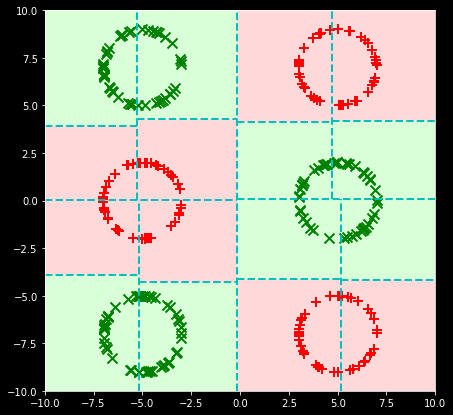

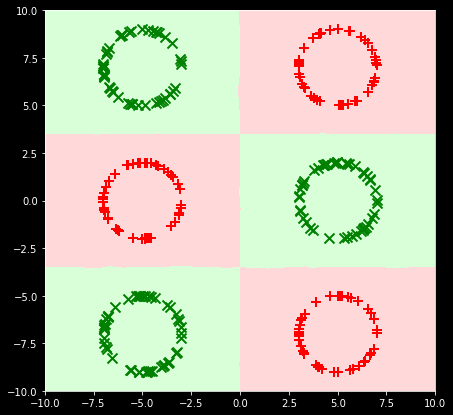

In [152]:
import numpy as np
from numpy import linalg as lin
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from matplotlib import pyplot as plt
import time as t

class Node:
    # A node stores its own depth (root = depth 0), its decision stump, its parent and child information
    # Leaf nodes also store a constant label that is assigned to every data point that reaches that leaf
    def __init__( self, depth = 0, stump = (0,0), parent = None ):
        self.depth = depth
        self.stump = stump
        self.parent = parent
        self.left = None
        self.right = None
        self.isLeaf = True
        self.label = 0
        
    def predict( self, data ):
        # If I am a leaf I can predict rightaway
        # May change this constant leaf action to something more interesting and powerful
        if self.isLeaf:
            return self.label
        # Else I have to ask one of my children to do the job
        else:
            if data[self.stump[0]] > self.stump[1]:
                return self.right.predict( data )
            else:
                return self.left.predict( data )
            
    # Get the Gini coefficient of a node with nPos positive points and nNeg negative points
    def getGini( self, nPos, nNeg ):
        nTot = nPos + nNeg
        # Find the proportion of the positives and negatives in that node
        pPos = nPos/nTot
        pNeg = nNeg/nTot
        # The gini index is always a real number between 0 and 0.5
        # A perfectly pure node has gini index = 0
        # The smaller the gini index the purer the node
        gini = 1 - (pPos**2 + pNeg**2)
        return gini
            
    def getStump( self, X, y ):
        # How many data points do I have at this node?
        n = y.size
        bestObjective = float('inf')
        
        # For each of the features in the data
        for i in range( X.shape[1] ):
            # Do not use the same feature as used by the parent node
            if self.parent is not None and i == self.parent.stump[0]:
                continue
            # Find out all values at which we can threshold that feature
            candidateThresholds = np.sort( X[:, i] )
            idx = np.argsort( X[:, i] )
            # The cumulative sum trick used here will work only if labels are binary 
            ySorted = y[idx]
            yCum = np.cumsum( ySorted )
            yCumRev = np.cumsum( ySorted[::-1] )[::-1]
            # For each possible threshold (except the ones at the extreme)
            for j in range( 1, candidateThresholds.size-1 ):
                # Give 0.5 weight to balance and 1 weight to purity of the two nodes
                candidateObjective = 0.0 * 0.0 \
                                    + 1.0 * self.getGini( (yCum[j] + j+1)/2, (j+1 - yCum[j])/2 ) \
                                    + 1.0 * self.getGini( (yCumRev[j+1] + n-j-1)/2, (n-j-1 - yCumRev[j+1])/2 )
                if candidateObjective < bestObjective:
                    bestObjective = candidateObjective
                    bestFeat = i
                    bestThresh = candidateThresholds[j]
        
        # Can try LwP decision stump as well
        bestThresh = (np.mean(X[y > 0, bestFeat]) + np.mean(X[y < 0, bestFeat]))/2
        return (bestFeat, bestThresh)
            
    def train( self, X, y, maxLeafSize, maxDepth ):
        # If too few data points are present, or else if this node is too deep in the tree, make this a leaf
        if y.size < maxLeafSize or self.depth >= maxDepth:
            self.isLeaf = True
            self.label = np.mean( y )
        else:
            # This node will be split and hence it is not a leaf
            self.isLeaf = False
            # Get the best possible decision stump
            self.stump = self.getStump( X, y )
            self.left = Node( depth = self.depth + 1, parent = self )
            self.right = Node( depth = self.depth + 1, parent = self )
            # Find which points go to my left child and which go to my right child
            discriminant = X[:, self.stump[0]] - self.stump[1]
            # Train my two children recursively
            self.left.train( X[discriminant <= 0, :], y[discriminant <= 0], maxLeafSize, maxDepth )
            self.right.train( X[discriminant > 0, :], y[discriminant > 0], maxLeafSize, maxDepth )

class Tree:
    def __init__( self, maxLeafSize = 10, maxDepth = 5 ):
        self.root = Node()
        self.maxLeafSize = maxLeafSize
        self.maxDepth = maxDepth 
        
    def predict( self, xt, yt ):
        return self.root.predict( np.array( [xt, yt] ) )
    
    def train( self, X, y ):
        self.root.train( X, y, self.maxLeafSize, self.maxDepth )

d = 2 
n = 50
r = 2

tmp1 = gsd.genSphericalData( d, n, [-5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [-5, 7], r )
XPos = np.vstack( (tmp1, tmp2, tmp3) )
yPos = np.ones( (3*n,) )

tmp1 = gsd.genSphericalData( d, n, [5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [-5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [5, 7], r )
XNeg = np.vstack( (tmp1, tmp2, tmp3) )
yNeg = -np.ones( (3*n,) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

DT = Tree( maxLeafSize = 5, maxDepth = 4 )
DT.train( X, y )

def drawTreeSplits( node, fig, xlim, ylim ):
    if not node.isLeaf:
        plt.figure( fig.number )
        # Is this a vertical split or a horizontal one?
        if node.stump[0] == 0:
            plt.plot( [node.stump[1], node.stump[1]], ylim, color = 'c', linestyle = '--' )
            drawTreeSplits( node.left, fig, [xlim[0], node.stump[1]], ylim )
            drawTreeSplits( node.right, fig, [node.stump[1], xlim[1]], ylim )
        elif node.stump[0] == 1:
            plt.plot( xlim, [node.stump[1], node.stump[1]], color = 'c', linestyle = '--' )
            drawTreeSplits( node.left, fig, xlim, [ylim[0], node.stump[1]] )
            drawTreeSplits( node.right, fig, xlim, [node.stump[1], ylim[1]] )
            
def kNNClass( xt, yt ):
    diff = X - np.array( [xt, yt] )
    dist = lin.norm( diff, axis = 1 )
    idx = np.argsort( dist )
    yhat = 0
    wsum = 0
    for i in range( k ):
        yhat = yhat + y[idx[i]]
    return yhat/k

fig = pd.getFigure()
tic = t.process_time()
pd.shade2D( DT.predict, fig, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading with a DT")
drawTreeSplits(DT.root, fig, xlim = [-10, 10],  ylim = [-10, 10])
pd.plot2D( XNeg, fig, color = 'r', marker = '+' )
pd.plot2D( XPos, fig, color = 'g', marker = 'x' )

k = 1
fig2 = pd.getFigure()
tic = t.process_time()
pd.shade2D( kNNClass, fig2, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
toc = t.process_time()
print( "It took " + str(toc - tic) + " seconds to complete the shading with kNN")
pd.plot2D( XNeg, fig2, color = 'r', marker = '+' )
pd.plot2D( XPos, fig2, color = 'g', marker = 'x' )
print( "DTs get faster compared to kNN as number of training points increases - set n = 500 and see" )

## Problem

1. Can you change the DT to use information gain instead of Gini impurity for the criterion split
2. Can you use the DT learning code given here to train a DT with this dataset ([link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29))?
3. Experiment with the tree hyperparameters using cross-validation to see what sort of tree works best for this dataset.

Slightly different dataset used: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

In [153]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [154]:
data=pd.read_csv('breast-cancer-wisconsin.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [155]:
data.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [156]:
#dropping useless columns
data = data.drop(['Unnamed: 32'], axis=1)
data = data.drop(['id'], axis=1)

In [157]:
data.isnull().sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [158]:
data.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [159]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('Solarize_Light2')
plt.style.use('dark_background')

Text(0.5, 1.0, 'Correlation between Features')

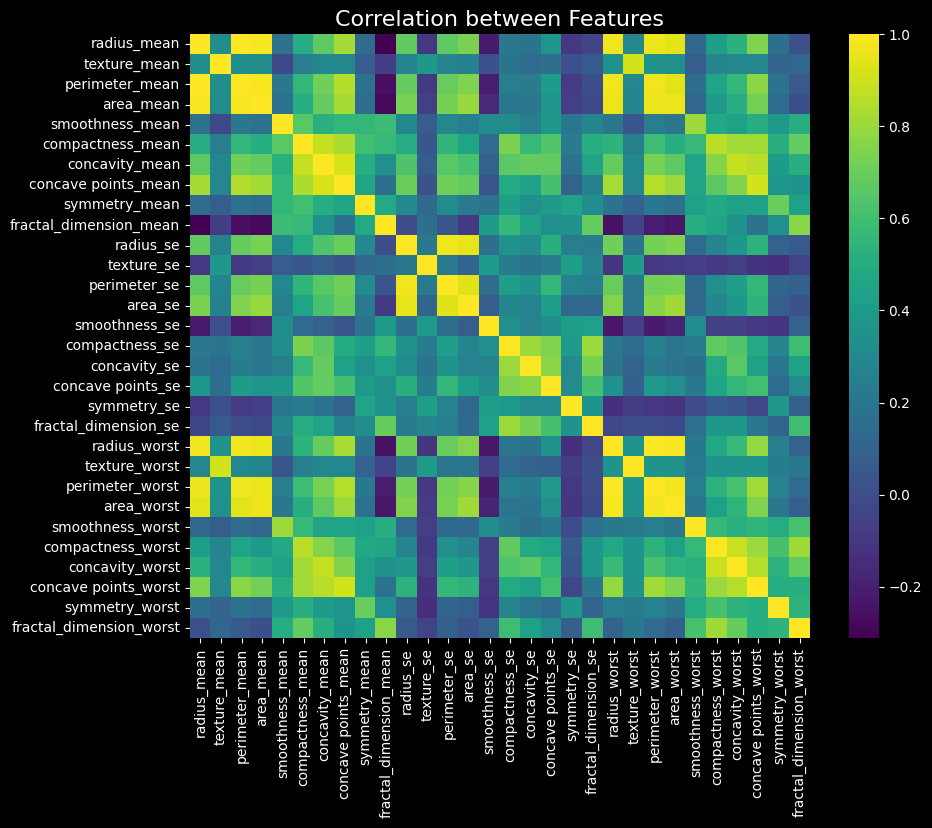

In [161]:
# Heat map visualization to figure out the correlations
plt.figure(figsize=(10,8), dpi=100)
sns.heatmap(data.corr(), cmap='viridis')
plt.title("Correlation between Features")

In [162]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [163]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [164]:
features = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

In [165]:
#now convering the making the output numerical
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
data['diagnosis']= label_encoder.fit_transform(data['diagnosis'])

In [166]:
X = data[features]
y = data['diagnosis']

In [167]:
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [168]:
from sklearn.preprocessing import StandardScaler
z = StandardScaler()

X[features] = z.fit_transform(X[features])

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [169]:
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # 80% training and 20% test

In [171]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [172]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print("F1 score: ",f1_score(y_test, y_pred))

Accuracy score:  0.956140350877193
Precision score:  0.9512195121951219
Recall score:  0.9285714285714286
F1 score:  0.9397590361445782


In [173]:
from sklearn.tree import DecisionTreeRegressor 
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
# fit the regressor with X and Y data
regressor.fit(X, y)

y_pred = regressor.predict(X_test)

In [174]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print("F1 score: ",f1_score(y_test, y_pred))

Accuracy score:  1.0
Precision score:  1.0
Recall score:  1.0
F1 score:  1.0


In [175]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [2, 3]}

gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=15,
                     verbose=1, 
                     scoring='accuracy')

gs_DT.fit(X,y);

Fitting 15 folds for each of 32 candidates, totalling 480 fits


In [176]:
gs_DT.best_params_

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}

In [177]:
gs_DT.best_score_

0.947321005215742

In [178]:
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']
results_DT.columns

Index(['criterion', 'max_depth', 'min_samples_split', 'test_score'], dtype='object')

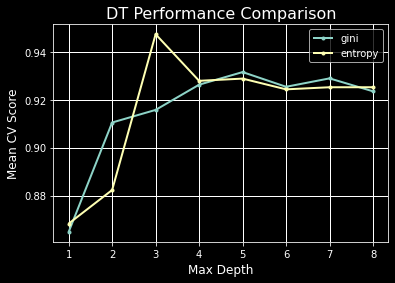

In [179]:
for i in ['gini', 'entropy']:
    temp = results_DT[results_DT['criterion'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = i)
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

In [180]:
clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=6, min_samples_split=3, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [182]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print("F1 score: ",f1_score(y_test, y_pred))

Accuracy score:  0.9473684210526315
Precision score:  0.9285714285714286
Recall score:  0.9285714285714286
F1 score:  0.9285714285714286


In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [184]:
clf = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=2,random_state=0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rand_frst_score1 = clf.score(X_test, y_test)
print('random_forest_score: ',rand_frst_score1)
confusion_matrix(y_test, y_pred)

random_forest_score:  0.9473684210526315


array([[71,  1],
       [ 5, 37]])

In [185]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print("F1 score: ",f1_score(y_test, y_pred))

Accuracy score:  0.9473684210526315
Precision score:  0.9736842105263158
Recall score:  0.8809523809523809
F1 score:  0.925


In [186]:
clf = RandomForestClassifier(criterion='entropy', n_estimators=100, max_depth=2,random_state=0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
rand_frst_score1 = clf.score(X_test, y_test)
print('random_forest_score: ',rand_frst_score1)
confusion_matrix(y_test, y_pred)

random_forest_score:  0.9122807017543859


array([[71,  1],
       [ 9, 33]])

In [187]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('Precision score: ', precision_score(y_test, y_pred))
print('Recall score: ', recall_score(y_test, y_pred))
print("F1 score: ",f1_score(y_test, y_pred))

Accuracy score:  0.9122807017543859
Precision score:  0.9705882352941176
Recall score:  0.7857142857142857
F1 score:  0.8684210526315789


# Decision Tree Accuracy
 
Entropy: 0.9561

Gini: 0.947

# Random Forest Accuracy

Entropy: 0.9122

Gini: 0.9473

# Inferences and Key takeaways:

Therefore we can see that for the given dataset, the decision tree based on entropy is better than on Gini. We also computed various permutations and combinations of the Gini and entropy and found that the entropy criterion works best for this given dataset. But, when exploring the application of the Random Forest ensemble method, we see a reversal in the trend, and the Gini index performs better in this case; although the overall accuracy isn't that far off from the one obtained from the decision tree.